In [23]:
import sys
import os
import numpy as np
import pandas as pd
import pickle as pickle
import sklearn
from sklearn.model_selection import train_test_split
# from PIL import Image
# import png
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
%matplotlib inline
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from skimage.color import convert_colorspace,rgb2gray

In [24]:
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [25]:
df_train = pd.read_csv("../data/train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv("../data/test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv("../data/macro.csv", parse_dates=['timestamp'])

df_train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


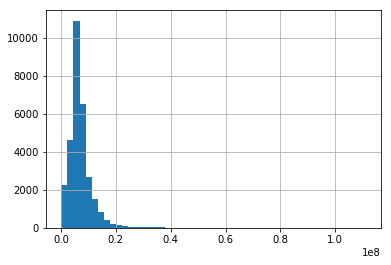

In [26]:
df_train['price_doc'].hist(bins=50)


In [27]:
y_train = df_train['price_doc'].values
id_test = df_test['id']

df_train.drop(['id', 'price_doc'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
df_all = df_all.join(df_macro, on='timestamp', rsuffix='_macro')
print(df_all.shape)

(38133, 390)


In [28]:
# Add month-year
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)

# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp', 'timestamp_macro'], axis=1, inplace=True)

In [29]:
# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

In [30]:
df_values=df_values.replace([np.inf, -np.inf], np.nan)
df_values=df_values.fillna(0)

In [31]:
# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

X_train = X_all[:num_train]
X_test = X_all[num_train:]

df_columns = df_values.columns

(38133, 394)


In [32]:
# ExtraTreesRegressor
modelName = 'ET'
clf = ExtraTreesRegressor(n_estimators=10, max_depth=3,
    min_samples_split=100, random_state=0)
clf = clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train)
print(scores)

[ 0.36376037  0.37176939  0.37661133]


In [33]:
# RandomForestRegressor
modelName = 'RF'
clf = RandomForestRegressor(n_estimators=10, max_depth=3,
    min_samples_split=100, random_state=0)
clf = clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train)
print(scores)

[ 0.4027559   0.48666262  0.53780978]


In [34]:
# RandomForestRegressor
modelName = 'RF'
clf = RandomForestRegressor(n_estimators=10, max_depth=3,
    min_samples_split=100, random_state=0)
y_train2 = np.log(y_train+1)
clf = clf.fit(X_train, y_train2)
scores = cross_val_score(clf, X_train, y_train2)
print(scores)

[ 0.21634052  0.30558361  0.33044539]


In [35]:
# GradientBoostingRegressor
modelName = 'GB'
clf = GradientBoostingRegressor(n_estimators=10, max_depth=3,
    min_samples_split=100, random_state=0)
clf = clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train)
print(scores)

[ 0.4173204   0.46582762  0.432405  ]


In [36]:
y_pred = clf.predict(X_test)
date = datetime.now().strftime("%Y%m%d_%H%M")
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
fout = '../data/'+date+"_"+modelName+'.csv'
df_sub.to_csv(fout, index=False)

In [39]:
y_pred = clf.predict(X_test)
#print(y_pred)
#y_pred = np.exp(y_pred)-1
date = datetime.now().strftime("%Y%m%d_%H%M")
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
fout = '../data/'+date+"_"+modelName+'.csv'
df_sub.to_csv(fout, index=False)

[ 5860227.09608296  7655673.91998689  6371815.44837857 ...,
  6331562.11099444  6085035.58024977  7816730.23046496]


In [ ]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)